### Packages 

In [2]:
# system packages
from itertools import islice
import pickle
import gc 
import sys
import time
import warnings
import os
from collections import Counter

# non-geo numeric packages
from joblib import Parallel, delayed
from multiprocessing.pool import ThreadPool 
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import product, combinations
import pandas as pd

# network and OSM packages
import networkx as nx
import osmnx as ox
city_geo = ox.geocoder.geocode_to_gdf

# Earth engine packages
import ee
import geemap

# General geo-packages
from rasterstats import zonal_stats
from pyproj import CRS
import libpysal
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rioxarray
import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Point, MultiLineString, LineString, Polygon, MultiPolygon
from pylandtemp import single_window

In [27]:
# latest gdf
popgridmanchester = gpd.read_file('popgridmanchesterlatest.gpkg')

# buffergdf
bufferintersect_gdf = gpd.read_file('bufferintersect_gdf_new.gpkg')

### GEE authentication/initialisation, path and folder creation, excel files for cities and city iso's, Global Administrative Unit Levels (GAUL) country boundaries

In [4]:
# Authenticate and Initialize Google Earth Engine
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AZEOvhWNhvTSuzX5l7jIkk4040kc7ZybKDco1o1htJesIGdXFDEhnePg_4s



Successfully saved authorization token.


In [ ]:
# Current directory path for extraction of the TIFF files
currentdir = os.getcwd()

# Create the new directory called 'GEE_city_grids' for the TIFF files to be stored in
path = os.path.join(currentdir, 'GEE_city_grids/')

# Creation of GEE_city_grids folder
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)

In [330]:
# Specify cities using the excel files with the cities and iso's

# Extract iso-3166 country codes for the population extraction
iso = pd.read_excel('iso_countries.xlsx')

# Extract all cities list
cities = pd.read_excel('cities.xlsx')

# 'cities_adj' serves by default as city-input for in the GEE extraction functions, needed for the OpenStreetMap area..
# ..from the cities excel file
# plug in the city of interest, 'Amsterdam' is the example
cities_adj = cities[cities['City'].isin(['Amsterdam'])]
cities_adj = cities_adj.reset_index()

# city of interest for in the functions
city = 'Amsterdam'

# get country iso
# get city country
city_country = city_geo(city).dissolve()['display_name'][0].rsplit(', ')[-1]
# get the country's iso-code
iso_code = iso[iso['name'] == city_country]['alpha3'].tolist()[0]

# determine the CRS projection in meters for the country of interest
# For example, Great Britain has EPSG 27700, the Netherlands has EPSG 32631
citycrs = 'EPSG:32631'
citycrsint = 32631 # the function city_grids_format uses two crs objects

# Get a feature collection of Global Administrative Unit Levels (GAUL) country boundaries..
# ..necessary for the clipping of the GEE image collection for the remote sensing data
# Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
# ..'GAUL Country Code'
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
# Amsterdam
GAUL_code = 177

### Functions to extract GEE population, NDVI, LST, DEM and Night Light data

In [271]:
# Function to extract worldpop data from GEE of the cities

def gee_worldpop_extract(city_file, path):
    
    # city of interest
    cities = city_file
    
    # Get included city areas
    OSM_area = cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_area).dissolve()['geometry'][0]

    # Based on the iso-code return the worldpop from 2020
    ee_worldpop = ee.ImageCollection("WorldPop/GP/100m/pop")\
        .filter(ee.Filter.date('2020'))\
        .filter(ee.Filter.eq('country', iso_code)).first()
        
    # Clip the countries with the city geoms.
    clipped = ee_worldpop.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + NLD_Amsterdam_2020.tif
    filenames = path+iso_code+'_'+city+'_2020.tif'

    # Export as TIFF file.
    geemap.ee_export_image(clipped, filenames)
    return(filenames)
    sys.stdout.flush()

In [1]:
# Function to extract NDVI data from GEE of Greater Manchester

def gee_NDVI_extract(city_file):
    
    # city of interest
    cities = city_file
    
    # Get included city areas
    OSM_incl = cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_incl).dissolve()['geometry'].tolist()[0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Return the mean of the collection of images with multispectral values over 2020
    vegetation = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                  .filter(ee.Filter.date('2020-01-01', '2020-12-31'))\
                  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', 5).mean() 
    
    # Calculating NDVI from the normalized difference of bands B8 and B4
    ndvi = vegetation.normalizedDifference(['B8', 'B4']).rename('NDVI')
    vegetation = vegetation.addBands(ndvi)
    
    # Select the added ndvi band
    ndvi_band = vegetation.select('NDVI')
    
    # Clip with country of interest
    ndvi_clip = ndvi_band.clip(country)

    # Clip the country with the city geoms
    clipped = ndvi_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Amsterdam_2020_NDVI.tif
    filenames = path+city+'_2020_NDVI.tif'

    # Export as TIFF file.
    # Also adjust scale and crs because when you reduce an image collection to a mean for example..
    # ..the result has a default projection that has 1-degree pixel size in WGS84 EPSG:4326
    geemap.ee_export_image(clipped, filename = filenames, scale=25, crs=citycrs)
    return(filenames)
    sys.stdout.flush()

In [81]:
# Function to extract LST data from GEE of Greater Manchester

def gee_LST_extract(city_file):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = cities[cities['City'] == city]['OSM_area'][0]

    # Get the city geoms
    obj = city_geo(OSM_incl).dissolve()['geometry'].tolist()[0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Return the mean of the collection of images with the global vegetation values of 2020
    landsat_8 = ee.ImageCollection('LANDSAT/LC08/C02/T1')\
                    .filter(ee.Filter.date('2020-01-01', '2020-12-31'))\
                    .filterMetadata('CLOUD_COVER','less_than', 20)
    
    # Select LST band from recording
    red = landsat_8.select('B4')
    nir = landsat_8.select('B5')
    thermal = landsat_8.select('B10')
    
    # Getting means over collection
    red_mean = red.mean()
    nir_mean = nir.mean()
    thermal_mean = thermal.mean()
    
    # Clip with UK country 
    red_clip = red_mean.clip(country)
    nir_clip = nir_mean.clip(country)
    thermal_clip = thermal_mean.clip(country)

    # Clip the country with the city geoms
    red_clipped = red_clip.clip(shapely.geometry.mapping(obj))
    nir_clipped = nir_clip.clip(shapely.geometry.mapping(obj))
    therm_clipped = thermal_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Amsterdam_2020_red.tif
    filenames_r = path+city+'_2020_red.tif'
    filenames_n = path+city+'_2020_nir.tif'
    filenames_th = path+city+'_2020_thermal.tif'

    # Export as TIFF file.
    # Stored in form path + Amsterdam_2020_red.tif
    geemap.ee_export_image(red_clipped, filename = filenames_r, scale=25, crs=citycrs)
    geemap.ee_export_image(nir_clipped, filename = filenames_n, scale=25, crs=citycrs)
    geemap.ee_export_image(therm_clipped, filename = filenames_th, scale=25, crs=citycrs)

    return(filenames_r, filenames_n, filenames_th)
    sys.stdout.flush()

In [275]:
# Function to extract DEM data from GEE of Greater Manchester

def gee_DEM_extract(city_file):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_incl).dissolve()['geometry'].tolist()[0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Downloading SRTM revised data
    srtm = ee.Image("NASA/NASADEM_HGT/001")
    dem = srtm.select('elevation')
    
    # Clip with UK country 
    dem_clip = dem.clip(country)

    # Clip the country with the city geoms
    clipped = dem_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Amsterdam_DEM.tif
    filenames = path+city+'_DEM.tif'

    # Export as TIFF file.
    # Also adjust scale and crs because when you reduce an image collection to a mean for example..
    # ..the result has a default projection that has 1-degree pixel size in WGS84 EPSG:4326
    geemap.ee_export_image(clipped, filename = filenames, scale=25, crs=citycrs)
    return(filenames)
    sys.stdout.flush()

In [111]:
# Function to extract Night Light data from GEE of Greater Manchester

def gee_NL_extract(city_file):
    
    # city of interest
    cities = city_file
    
    # Get included city area
    OSM_incl = cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ')

    # Get the city geom
    obj = city_geo(OSM_incl).dissolve()['geometry'].tolist()[0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Downloading mean of Night Light over 2022. 2022 because the start of the covid-19 pandemic might have had an impact on it. 
    nightlight_mean = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')\
                    .filter(ee.Filter.date('2022-01-01', '2022-12-31')).mean()
    
    # selecting the right avg_rad band, the other cf_cvg is for places with lower quality data
    nightlight = nightlight_mean.select('avg_rad')
    
    # Clip with UK country 
    nightlight_clip = nightlight.clip(country)

    # Clip the country with the city geoms
    clipped = nightlight_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Amsterdam_2022_NL.tif
    filenames = path+city+'_2022_NL.tif'

    # Export as TIFF file.
    # Also adjust scale and crs because when you reduce an image collection to a mean for example..
    # ..the result has a default projection that has 1-degree pixel size in WGS84 EPSG:4326
    geemap.ee_export_image(clipped, filename = filenames, scale=15, crs=citycrs)
    return(filenames)
    sys.stdout.flush()

### Function that creates a grid of square polygons containing the GEE population data per grid

In [355]:
# Function to create population grids of the cities

def city_grids_format(city_grids, cities_area, grid_size = 100):
    start_time = time.time()
    grids = []
    print(str(grid_size) + 'm resolution grids extraction')
        
    # Open the raster file
    with rasterio.open(city_grids) as src:
        band= src.read() # the population values
        aff = src.transform # the raster bounds and size (affine)

    # Get the rowwise arrays, get a 2D dataframe
    grid = pd.DataFrame()
    for b in enumerate(band[0]):
        grid = pd.concat([grid, pd.Series(b[1],name=b[0])],axis=1)
    grid= grid.unstack().reset_index()

    # Unstack df to columns
    grid.columns = ['row','col','value']
    grid['minx'] = aff[2]+aff[0]*grid['col']
    grid['miny'] = aff[5]+aff[4]*grid['row']
    grid['maxx'] = aff[2]+aff[0]*grid['col']+aff[0]
    grid['maxy'] = aff[5]+aff[4]*grid['row']+aff[4]

    # Create polygon from affine bounds and row/col indices
    grid['geometry'] = [Polygon([(grid.minx[i],grid.miny[i]),
                               (grid.maxx[i],grid.miny[i]),
                               (grid.maxx[i],grid.maxy[i]),
                               (grid.minx[i],grid.maxy[i])])\
                      for i in range(len(grid))]

    # Set the df as geo-df
    grid = gpd.GeoDataFrame(grid, crs = citycrsint) 

    # Get dissolvement_key for dissolvement. 
    grid['row3'] = np.floor(grid['row']/(grid_size/100)).astype(int)
    grid['col3'] = np.floor(grid['col']/(grid_size/100)).astype(int)
    grid['dissolve_key'] = grid['row3'].astype(str) +'-'+ grid['col3'].astype(str)

    # Define a city's OSM area as Polygon.
    # Get city area
    OSM_area = cities_adj[cities_adj['City'] == city]['OSM_area'].tolist()[0].rsplit(', ')
    # Get the city geom
    geo_ls = gpd.GeoSeries(city_geo(OSM_area).dissolve().geometry)
    geo_ls = geo_ls.to_crs(citycrs)

    # Intersect grids with the city boundary Polygon.
    insec = grid.intersection(geo_ls.tolist()[0])

    # Exclude grids outside the specified city boundaries
    insec = insec[insec.area > 0]

    # Join in other information.
    insec = gpd.GeoDataFrame(geometry = insec, crs = citycrsint).join(grid.loc[:, grid.columns != 'geometry'])

    # Dissolve into block by block grids
    popgrid = insec[['dissolve_key','geometry','row3','col3']].dissolve('dissolve_key')

    # Get those grids populations and area, only full blocks
    popgrid['population'] = round(insec.groupby('dissolve_key')['value'].sum()).astype(int)
    popgrid = popgrid[popgrid['population'] >= 0]

    # Get centroids and coords
    popgrid['centroid'] = popgrid['geometry'].centroid
    #popgrid['centroid_m'] = gpd.GeoSeries(popgrid['centroid'], crs = '27700').to_crs(3043)
    popgrid['grid_lon'] = popgrid['centroid'].x
    popgrid['grid_lat'] = popgrid['centroid'].y
    popgrid = popgrid.reset_index()

    minx = popgrid.bounds['minx']
    maxx = popgrid.bounds['maxx']
    miny = popgrid.bounds['miny']
    maxy = popgrid.bounds['maxy']

    # Some geometries result in a multipolygon when dissolving (like i.e. 0.05 meters), coords error.
    # Therefore recreate the polygon.
    Poly = []
    for k in range(len(popgrid)):
        Poly.append(Polygon([(minx[k],maxy[k]),(maxx[k],maxy[k]),(maxx[k],miny[k]),(minx[k],miny[k])]))
    popgrid['geometry'] = Poly

    grids.append(popgrid)

    print(city_grids.rsplit('_')[3], round((time.time() - start_time)/60,2),'mns')
    return(grids)

In [276]:
# Extracting the GEE data from the functions above

# Required preprocess for information extraction
warnings.filterwarnings('ignore')

# In essence, we use Google Earth Engine to extract a country's grid raster and clip it with the city's preferred OSM area
# Predefined in Excel: the (1) city name as "City" and (2) the OSM area that needs to be extracted as "OSM_area"
# i.e. City = "Los Angeles" and OSM_area = "Los Angeles county, Orange county CA"

# Greater Manchester
# popgrid = gee_worldpop_extract(cities_adj, iso, path)
# ndvi_man = gee_NDVI_extract(cities_adj)
# LST_man = gee_LST_extract(cities_adj)
# dem_man = gee_DEM_extract(cities_adj)
# NL_man = gee_NL_extract(cities_adj)

# Amsterdam
popgrid = gee_worldpop_extract(cities_adj, path)
ndvi_ams = gee_NDVI_extract(cities_adj)
LST_ams = gee_LST_extract(cities_adj)
dem_ams = gee_DEM_extract(cities_adj)
NL_ams = gee_NL_extract(cities_adj)

# Files are downloaded automatically to the specified path. Files are also stored in Google with a downloadlink:

Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/NLD_Amsterdam_2020.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/Amsterdam_2020_NDVI.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/Amsterdam_2020_red.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/Amsterdam_2020_nir.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/Amsterdam_2020_thermal.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/Amsterdam_DEM.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/

In [294]:
# convert population file to crs of interest with help from this adjusted code snippit from
# rasterio's reprojection documentation

dst_crs = citycrs

with rasterio.open(popgrid) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Split the popgrid path into directory and filename
    directory, filename = os.path.split(popgrid)

    # Split the filename into name and extension
    name, extension = os.path.splitext(filename)

    # Create new filename by appending "_proj" to the name
    proj_file = f"{name}_proj{extension}"

    # Create new path by joining the directory and new filename
    new_path = os.path.join(directory, proj_file)

    with rasterio.open(new_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

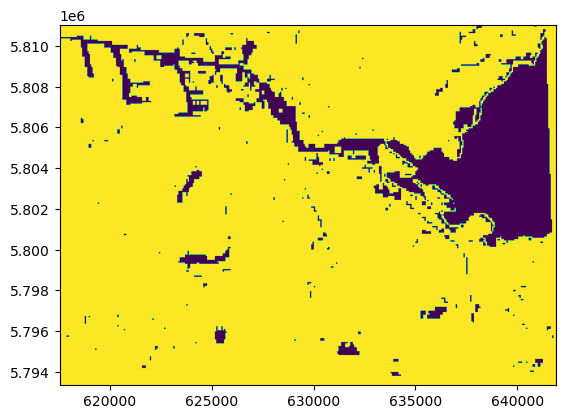

<AxesSubplot: >

In [341]:
# Plot the population TIFF image to check, looks good
fp = new_path
img = rasterio.open(fp)
show(img)

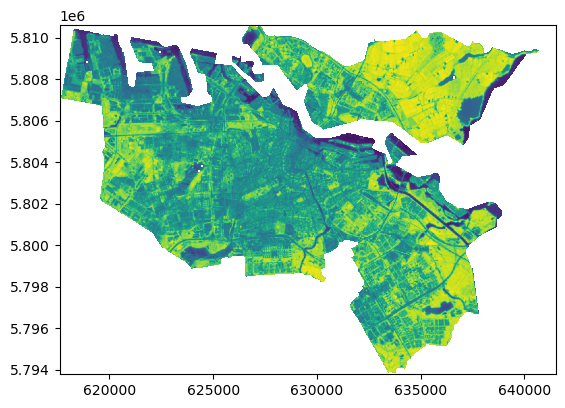

<AxesSubplot: >

In [284]:
# Plot the NDVI TIFF image to check, looks good
fp = path+'/Amsterdam_2020_NDVI.tif'
img = rasterio.open(fp)
show(img)

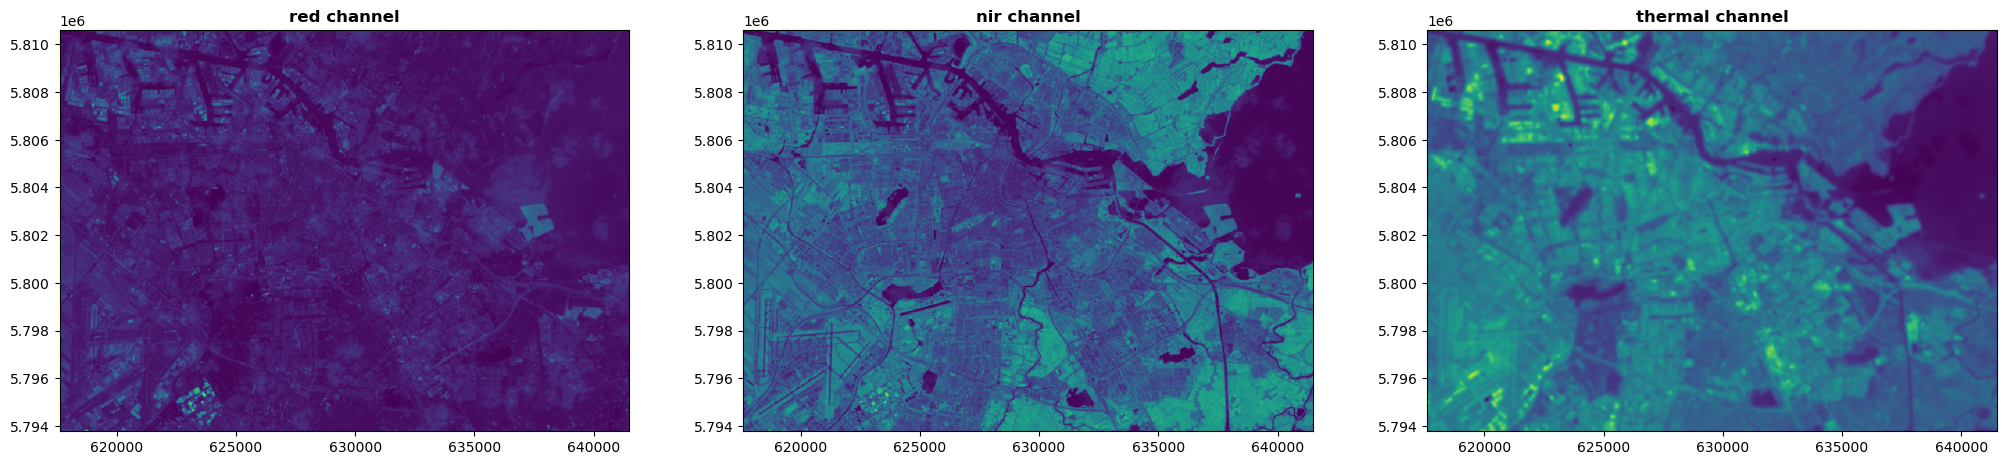

In [285]:
# Checking files
fp = path+'/Amsterdam_2020_red.tif'
fp2 = path+'/Amsterdam_2020_nir.tif'
fp3 = path+'/Amsterdam_2020_thermal.tif'
img = rasterio.open(fp)
img2 = rasterio.open(fp2)
img3 = rasterio.open(fp3)

# Plot
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(25,8))
show((img), ax=axr, title='red channel')
show((img2), ax=axg, title='nir channel')
show((img3), ax=axb, title='thermal channel')
plt.show()

In [286]:
# Calculate LST layer

# Load in each band that was exported from GEE
red = rasterio.open(path+'/Amsterdam_2020_red.tif')
nir = rasterio.open(path+'/Amsterdam_2020_nir.tif')
thermal = rasterio.open(path+'/Amsterdam_2020_thermal.tif')

# Read the bands to be used for calculation
redImage = red.read(1).astype('f4')
nirImage = nir.read(1).astype('f4')
thermalImage = thermal.read(1).astype('f4')

lst_image_single_window = single_window(thermalImage, redImage, nirImage, unit='celcius')
lst_image_single_window = lst_image_single_window - 273.15

# Define affine transformation
affine = red.transform
crs_red = citycrs

# Create new raster file with calculated variables
with rasterio.open(
    path+"/Amsterdam_2020_LST.tif",
    mode="w",
    driver="GTiff",
    height=lst_image_single_window.shape[0],
    width=lst_image_single_window.shape[1],
    count=1,
    dtype=lst_image_single_window.dtype,
    crs=crs_red,
    transform=affine,
                    ) as new_dataset:
        new_dataset.write(lst_image_single_window, 1)

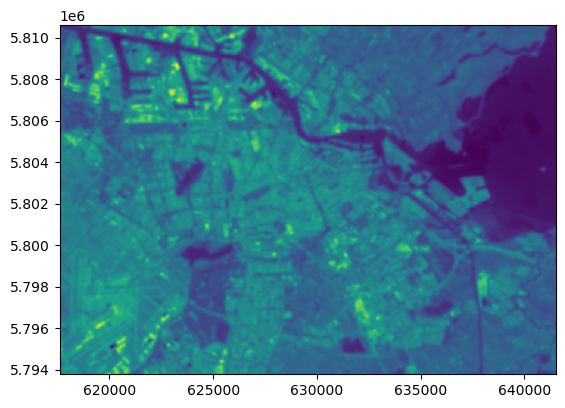

<AxesSubplot: >

In [287]:
# Checking LST file
fp = path+'/Amsterdam_2020_LST.tif'
img = rasterio.open(fp)
show(img)

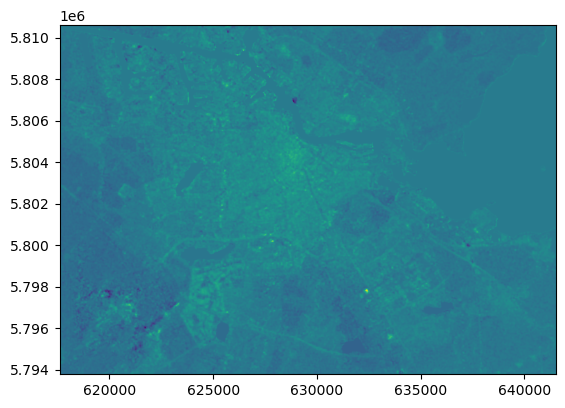

<AxesSubplot: >

In [288]:
# Checking DEM file
fp = path+'/Amsterdam_DEM.tif'
img = rasterio.open(fp)
show(img)

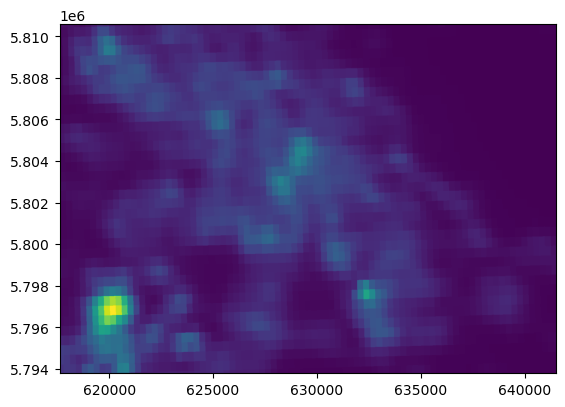

<AxesSubplot: >

In [289]:
# Checking NightLight file
fp = path+'/Amsterdam_2022_NL.tif'
img = rasterio.open(fp)
show(img)

In [292]:
path

'/Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/'

In [364]:
# Creation of the population grid

# Clip cities from countriepopulationformat population grids
population_grids = city_grids_format(new_path,
                                     cities_adj['OSM_area'],
                                     grid_size = 100) # aggregating upwards to i.e. 200m, 300m etc. is possible
print(' ')

# Save the dataframe
popgridamsterdam = population_grids[0]

In [370]:
popgridamsterdam

,dissolve_key,geometry,row3,col3,population,centroid,grid_lon,grid_lat
0,10-142,"POLYGON ((626611.024 5810399.809, 626670.080 5...",10,142,17,POINT (626648.623 5810363.911),626648.622659,5.810364e+06
1,10-143,"POLYGON ((626670.080 5810399.809, 626733.988 5...",10,143,18,POINT (626702.034 5810367.855),626702.034028,5.810368e+06
2,10-144,"POLYGON ((626733.988 5810399.809, 626797.896 5...",10,144,15,POINT (626765.942 5810367.855),626765.941829,5.810368e+06
3,10-145,"POLYGON ((626797.896 5810399.809, 626861.804 5...",10,145,12,POINT (626829.850 5810367.855),626829.849631,5.810368e+06
4,10-146,"POLYGON ((626861.804 5810399.809, 626925.711 5...",10,146,15,POINT (626893.757 5810367.855),626893.757432,5.810368e+06
...,...,...,...,...,...,...,...,...
48325,99-95,"POLYGON ((623602.506 5804712.014, 623666.413 5...",99,95,38,POINT (623634.460 5804680.060),623634.459568,5.804680e+06
48326,99-96,"POLYGON ((623666.413 5804712.014, 623730.321 5...",99,96,41,POINT (623698.367 5804680.060),623698.367369,5.804680e+06
48327,99-97,"POLYGON ((623730.321 5804712.014, 623794.229 5...",99,97,39,POINT (623762.275 5804680.060),623762.275171,5.804680e+06
48328,99-98,"POLYGON ((623794.229 5804712.014, 623858.137 5...",99,98,39,POINT (623826.183 5804680.060),623826.182972,5.804680e+06


In [ ]:
# Adding grid_lat/lon from 4326 for OSMNX distance calculations
popgridmanchester = popgridmanchester.to_crs("EPSG:4326")
popgridmanchester['centroid'] = popgridmanchester.geometry.centroid
popgridmanchester['grid_lon_4326'] = popgridmanchester['centroid'].x
popgridmanchester['grid_lat_4326'] = popgridmanchester['centroid'].y
popgridmanchester = popgridmanchester.to_crs("EPSG:27700")

In [ ]:
# Remove centroid to be able to save it as a GPKG
popgridmanchester = popgridmanchester.drop(columns=['centroid'])

In [ ]:
# Save as gkpg file
popgridmanchester.to_file("popgridmanchester3.gpkg", driver="GPKG")

### Create data points such as bus stops and restaurants

In [ ]:
# extract Greater Manchester polygon using OSM
manchester_osm = city_geo('Greater Manchester')

In [ ]:
# using OSM to extract data points

# specifying correct ESPG
epsg = "EPSG:27700"

# specifying the Greater Manchester polygon
manchester_poly = manchester_osm.geometry.unary_union

# extracting bus stops
bus_stops = ox.geometries_from_polygon(manchester_poly, tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs(epsg)
bus_stops = bus_stops[['geometry']]
bus_stops = bus_stops.reset_index()

# extracting restaurants
restaurants = ox.geometries_from_polygon(manchester_poly, tags={'amenity': ['bar', 'pub', 'restaurant', 'cafe']})
restaurants = restaurants.to_crs(epsg)
restaurants = restaurants[['geometry']]
restaurants = restaurants.reset_index()

# extracting daily shops
shops = ox.geometries_from_polygon(manchester_poly, tags={'shop': ['department_store', 'supermarket', 'convenience']})
shops.to_crs(epsg)
shops = shops[['geometry']]
shops = shops.reset_index()

# extracting cyclelanes
cycleways = ox.geometries_from_polygon(manchester_poly, tags={'cycleway': True, 'highway':'cycleway'})
cycleways.to_crs(epsg)
cycleways_c = cycleways[['geometry']]
cycleways_c = cycleways_c.reset_index()

#Create union out of all geometry extracted
temp_list = []

for index, x in cycleways_c.iterrows():
    temp_list.append(x.geometry)

series = gpd.GeoSeries(temp_list)

# convert to gdf and export as gpkg
cycleways_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(series))
#cycleways_gdf.to_file("cycleways.gpkg", driver="GPKG")

### Creating grid bufferzones and calculating population sum per grid bufferzone

In [123]:
# Create bufferzone dataframe from population grid dataframe geometries
buffer_gdf = popgridmanchester.copy()
buffer_gdf['centroid'] = buffer_gdf['geometry'].centroid
buffer_gdf['buffer'] = buffer_gdf['centroid'].buffer(500)
buffer_gdf = buffer_gdf['buffer']
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer')

In [126]:
# Intersect with bounds of the OSM city area so buffers don't extent beyond city borders
manpoly = city_geo('Greater Manchester').dissolve()['geometry']
manpoly = manpoly.to_crs("EPSG:27700")

# Intersection function to be called by the multiprocessing starmap() function
def get_intersection(gdf, other):
    return gdf.intersection(other)

# Using multiprocessing to create bufferzones that intersect with the Greate Manchester area to
# make sure the buffers do not extend beyond the borders
if __name__ == '__main__':
    # initialization with lowers threads and rows due to kernel crashing
    p1 = ThreadPool(2)
    bufferintersect = p1.starmap(get_intersection, [(buffer_gdf[0:1], manpoly.geometry[0])])
    p1.terminate()
    p1.join()
    # all threads
    p2 = ThreadPool()
    start_time = time.time()
    bufferintersect = p2.starmap(get_intersection, [(buffer_gdf, manpoly.geometry[0])])
    p2.terminate()
    p2.join()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

# I tried intersecting with a dissolved polygon from the population grid intstead of with a dissolved
# polygon from the OSM city area, because the population grid polygon contains small areas with no data
# that would then not be present within the buffers. Using rasterstats with that intersection would then 
# minimize the amount of missing data set to a negative number. This took too much time however.
# Might try again later.

Execution time: 429.53697299957275 seconds


In [ ]:
# Convert to gdf and save to gpkg
bufferintersect_gdf = gpd.GeoDataFrame(bufferintersect).T
bufferintersect_gdf = bufferintersect_gdf.rename(columns={0: "geometry"})
bufferintersect_gdf.geometry = bufferintersect_gdf['geometry']
bufferintersect_gdf = gpd.GeoDataFrame(bufferintersect_gdf)
bufferintersect_gdf = bufferintersect_gdf.set_crs("EPSG:27700")
bufferintersect_gdf.to_file("bufferintersect_gdf_new.gpkg", driver="GPKG")

In [6]:
# Open the buffergintersect_gdf file
bufferintersect_gdf = gpd.read_file("bufferintersect_gdf_new.gpkg")

In [29]:
# Use the population TIF
#with rasterio.open('/Users/julia/Scriptie_repo/MultiHealth_J/GEE_city_grids/GBR_Manchester_2020_proj.tif') as src:
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020_proj.tif') as src:
    affine = src.transform
    array = src.read(1)

# Get population sum statistic per bufferzone
def get_zonal_stats(buffergdf):
    return zonal_stats(buffergdf, array, affine=affine, stats=['sum'], nodata=0)

# Applying function via multiprocessing, not joblib due to non-iterable variable
if __name__ == '__main__':
    # Initialization with lowers threads and rows due to kernel crashing
    p1 = ThreadPool(2)
    statistics = p1.map(get_zonal_stats, [bufferintersect_gdf[0:1]])
    p1.terminate()
    p1.join()
    # All threads
    p2 = ThreadPool()
    start_time = time.time()
    statistics = p2.map(get_zonal_stats, [bufferintersect_gdf])
    p2.terminate()
    p2.join()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 680.1848838329315 seconds


In [40]:
# Extract the population sum per buffer from statistics
# Setting values to zero if negative or None 
population_sums = [stat['sum'] if (stat and 'sum' in stat and stat['sum'] >= 0) else 0 for sublist in statistics for stat in sublist]

# Converting to df to add to the population grid gdf
population_sums_df = pd.DataFrame(population_sums, columns={'buffer_population': population_sums})

# Adding index to merge
population_sums_df['index'] = population_sums_df.index

# Adding as column to popgridmanchester
popgridmanchester = popgridmanchester.merge(population_sums_df, on='index')

### Average NDVI per grid bufferzone

In [12]:
# Use the NDVI TIF
#with rasterio.open('GEE_city_grids/Manchester_2020_NDVI.tif') as src:
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/Manchester_2020_NDVI.tif'') as src:
    affine = src.transform
    array = src.read(1)

# Get NDVI mean statistic per bufferzone
def get_zonal_stats(buffergdf):
    return zonal_stats(buffergdf, array, affine=affine, stats=['mean'], nodata=0)

# Applying function via multiprocessing, not joblib due to non-iterable variable
if __name__ == '__main__':
    # Initialization with lowers threads and rows due to kernel crashing
    p1 = ThreadPool(2)
    statistics_ndvi = p1.map(get_zonal_stats, [bufferintersect_gdf[0:1]])
    p1.terminate()
    p1.join()
    # All threads
    p2 = ThreadPool()
    start_time = time.time()
    statistics_ndvi = p2.map(get_zonal_stats, [bufferintersect_gdf])
    p2.terminate()
    p2.join()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 486.6859803199768 seconds


In [110]:
# Extract the NDVI mean per buffer from statistics
# Setting values to zero if negative or None
ndvi_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) else 0 for sublist in statistics_ndvi for stat in sublist]

# Converting to df to add to the population grid gdf
ndvi_means_df = pd.DataFrame(ndvi_means, columns={'buffer_NDVI_mean': ndvi_means})

# Adding index to merge
ndvi_means_df['index'] = ndvi_means_df.index

# Adding as column to popgridmanchester
popgridmanchester = popgridmanchester.merge(ndvi_means_df, on='index')

### Average LST per grid bufferzone

In [112]:
# use the LST TIF
#with rasterio.open('GEE_city_grids/Manchester_2020_LST.tif') as src:
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/Manchester_2020_LST.tif'') as src:
    affine = src.transform
    array = src.read(1)

# Get LST mean statistic per bufferzone
def get_zonal_stats(buffergdf):
    return zonal_stats(buffergdf, array, affine=affine, stats=['mean'], nodata=0)

# Applying function via multiprocessing, not joblib due to non-iterable variable
if __name__ == '__main__':
    # Initialization with lowers threads and rows due to kernel crashing
    p1 = ThreadPool(2)
    statistics_lst = p1.map(get_zonal_stats, [bufferintersect_gdf[0:1]])
    p1.terminate()
    p1.join()
    # All threads
    p2 = ThreadPool()
    start_time = time.time()
    statistics_lst = p2.map(get_zonal_stats, [bufferintersect_gdf])
    p2.terminate()
    p2.join()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 500.45883083343506 seconds


In [113]:
# Extract the LST mean per buffer from statistics
# Setting values to zero if negative or None
lst_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) else 0 for sublist in statistics_lst for stat in sublist]

# Converting to df to add to the population grid gdf
lst_means_df = pd.DataFrame(lst_means, columns={'buffer_LST_mean': lst_means})

# Adding index to merge
lst_means_df['index'] = lst_means_df.index

# Add as column to popgridmanchester
popgridmanchester = popgridmanchester.merge(lst_means_df, on='index')

### Average DEM per grid bufferzone

In [114]:
# Use the DEM TIF
#with rasterio.open('GEE_city_grids/Manchester_2020_DEM.tif') as src:
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/Manchester_2020_DEM.tif') as src:
    affine = src.transform
    array = src.read(1)

# Get DEM mean statistic per bufferzone
def get_zonal_stats(buffergdf):
    return zonal_stats(buffergdf, array, affine=affine, stats=['mean'], nodata=0)

# Applying function via multiprocessing, not joblib due to non-iterable variable
if __name__ == '__main__':
    # Initialization with lowers threads and rows due to kernel crashing
    p1 = ThreadPool(2)
    statistics_dem = p1.map(get_zonal_stats, [bufferintersect_gdf[0:1]])
    p1.terminate()
    p1.join()
    # All threads
    p2 = ThreadPool()
    start_time = time.time()
    statistics_dem = p2.map(get_zonal_stats, [bufferintersect_gdf])
    p2.terminate()
    p2.join()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 495.6052129268646 seconds


In [115]:
# Extract the DEM mean per buffer from statistics
# Setting values to zero if negative or None
dem_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) else 0 for sublist in statistics_dem for stat in sublist]

# Converting to df to add to the population grid gdf
dem_means_df = pd.DataFrame(dem_means, columns={'buffer_DEM_mean': dem_means})

# Adding index to merge
dem_means_df['index'] = dem_means_df.index

# Add as column to popgridmanchester
popgridmanchester = popgridmanchester.merge(dem_means_df, on='index')

### Average Night Light per grid bufferzone

In [274]:
# Use the Night Light TIF
#with rasterio.open('GEE_city_grids/Manchester_2020_DEM.tif') as src:
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/Manchester_2022_NL.tif') as src:
    affine = src.transform
    array = src.read(1)

# Get Night Light mean statistic per bufferzone
def get_zonal_stats(buffergdf):
    return zonal_stats(buffergdf, array, affine=affine, stats=['mean'], nodata=0)

# Applying function via multiprocessing, not joblib due to non-iterable variable
if __name__ == '__main__':
    # Initialization with lowers threads and rows due to kernel crashing
    p1 = ThreadPool(2)
    statistics_nl = p1.map(get_zonal_stats, [bufferintersect_gdf[0:1]])
    p1.terminate()
    p1.join()
    # All threads
    p2 = ThreadPool()
    start_time = time.time()
    statistics_nl = p2.map(get_zonal_stats, [bufferintersect_gdf])
    p2.terminate()
    p2.join()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 748.0786471366882 seconds


In [275]:
# Extract the Night Light mean per buffer from statistics
# Setting values to zero if negative or None
nl_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) else 0 for sublist in statistics_nl for stat in sublist]

# Converting to df to add to the population grid gdf
nl_means_df = pd.DataFrame(nl_means, columns={'buffer_NightLight_mean': nl_means})

# Adding index to merge
nl_means_df['index'] = nl_means_df.index

# Add as column to popgridmanchester
popgridmanchester = popgridmanchester.merge(nl_means_df, on='index')

### Population density per grid bufferzone

In [57]:
# Adding population per buffer to buffer_gdf and then calculating density
bufferintersect_gdf['buffer_area'] = bufferintersect_gdf['geometry'].area

# Adding both buffer population and buffer area columns to final gdf for other density calculations
#popgridmanchester['buffer_population'] = population_sums_df['buffer_population']
popgridmanchester['buffer_area'] = bufferintersect_gdf['buffer_area']

# Calculating population density per buffer
popgridmanchester['buffer_pop_density'] = popgridmanchester['buffer_population']/popgridmanchester['buffer_area']

In [ ]:
# Drop centroid to save it as gpkg
popgridmanchester = popgridmanchester.drop(columns=['centroid'])
popgridmanchester.to_file("popgridmanchester3.gpkg", driver="GPKG")

### Extracting street networks per grid bufferzone and retrieving network statistics

In [43]:
# Download whole street network of Greater Manchester from osmnx and project to CRS 27700
G = ox.graph_from_place('Greater Manchester', network_type='all', simplify=True)
Gproj = ox.project_graph(G, to_crs="27700")

# Save to graphml
ox.io.save_graphml(Gproj, 'network.graphml')

In [71]:
# Open graphml
Gproj = ox.load_graphml('network.graphml')

In [ ]:
# Get subgraphs for each grid instead of extracting the network per grid, seems to be incredibly fast!
# Use the nodes from the whole street network of Greater Manchester, calculate their intersections 
# with buffer polygons and create the subgraph based on those intersected nodes.

# The function that returns the subgraph, it is called in the multiprocessing Parallel() function.
def get_subgraph(Gproj, Gproj_nodes, polygon):
    return Gproj.subgraph(Gproj_nodes[Gproj_nodes.intersects(polygon)].index)

# Get nodes from the Gproj 
Gproj_nodes = ox.graph_to_gdfs(Gproj, edges=False)

# Applying function via multiprocessing
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_list = Parallel(n_jobs=2, prefer="threads")(delayed(get_subgraph)(Gproj, Gproj_nodes, polygon) 
                                                         for polygon in bufferintersect_gdf[0:1].geometry)
    # All cores
    start_time = time.time()
    subgraph_list = Parallel(n_jobs=-1, prefer="threads")(delayed(get_subgraph)(Gproj, Gproj_nodes, polygon) 
                                                          for polygon in bufferintersect_gdf.geometry)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

In [ ]:
# Getting the basic stats of every subgraph by turning the subgraph into a gdf, turning that into 
# one polygon via .convex_hull and getting its area.

# Function that is called in the multiprocessing Parallel() function
def get_subgraph_area(subgraph):
    try:
        return ox.graph_to_gdfs(subgraph, nodes=True, edges=False).unary_union.convex_hull.area
    except ValueError:
        return 0

# Applying the function via multiprocessing
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_area = Parallel(n_jobs=2, prefer="threads")(delayed(get_subgraph_area)(subgraph) 
                                                         for subgraph in subgraph_list[0:1])
    # All cores
    start_time = time.time()
    subgraph_area = Parallel(n_jobs=-1, prefer="threads")(delayed(get_subgraph_area)(subgraph) 
                                                          for subgraph in subgraph_list)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

In [ ]:
# Get the statistics from each subgraph and area and accounting for the errors that might occur due
# to a graph having no edges and giving a ValueError or due to the area being zero because the area
# is not able to be calculated from a graph with no edges!

# Function that is called in the multiprocessing Parallel() function
def get_stats(subgraph, area):
    try:
        return ox.stats.basic_stats(subgraph, area)
    except (ValueError, ZeroDivisionError):
        return 0

# Applying the function via multiprocessing, still took 23 hours..
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_stats = Parallel(n_jobs=2, prefer="threads")(delayed(get_stats)(subgraph, area) 
                                                          for subgraph, area in islice(zip(subgraph_list, subgraph_area), 0, 1))
    # All cores
    start_time = time.time()
    subgraph_stats = Parallel(n_jobs=-1, prefer="threads")(delayed(get_stats)(subgraph, area) 
                                                           for subgraph, area in zip(subgraph_list, subgraph_area))
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

In [93]:
# Saving stats per subgraph, still took 23 hours..
# Also rename and convert the dict of statistics in each row to dataframe columns with json_normalize
subgraphstats= pd.DataFrame(np.array(subgraph_stats))
subgraphstats = subgraphstats.rename(columns={0: "stats"})
subgraphstats = pd.json_normalize(subgraphstats['stats'])
subgraphstats.to_pickle("subgraph_stats.pkl")

In [94]:
# Open subgraphs pkl
subgraphstats = pd.read_pickle('subgraph_stats.pkl')

In [96]:
# Remove columns that have lots of missing values
np.isnan(subgraphstats).sum() # check nans per columns

n                                  15165
m                                  15165
k_avg                              15165
edge_length_total                  15165
edge_length_avg                    15165
streets_per_node_avg               15165
intersection_count                 15165
street_length_total                15165
street_segment_count               15165
street_length_avg                  15165
circuity_avg                       15165
self_loop_proportion               15165
node_density_km                    15165
intersection_density_km            15165
edge_density_km                    15165
street_density_km                  15165
streets_per_node_counts.0          15165
streets_per_node_counts.1          15165
streets_per_node_counts.2          15165
streets_per_node_counts.3          15165
streets_per_node_counts.4          51135
streets_per_node_proportions.0     15165
streets_per_node_proportions.1     15165
streets_per_node_proportions.2     15165
streets_per_node

In [97]:
# Remove columns that have lots of missing values
subgraphstats = subgraphstats.drop(columns=['streets_per_node_counts.4',
                                            'streets_per_node_proportions.4', 
                                            'streets_per_node_counts.5', 
                                            'streets_per_node_proportions.5',
                                            'streets_per_node_counts.6',
                                            'streets_per_node_proportions.6',
                                            'streets_per_node_counts.7',
                                            'streets_per_node_counts.8',
                                            'streets_per_node_proportions.7', 
                                            'streets_per_node_proportions.8'])

# Add index to merge on index
subgraphstats['index'] = subgraphstats.index

# Concatenate the rest with the population grid gdf
popgridmanchester = popgridmanchester.merge(subgraphstats, on='index')

In [301]:
# Save the file to gpkg
popgridmanchester.to_file('popgridmanchesterlatest.gpkg', driver="GPKG")

### Checking if the rows with missing street network statistics can be filled with density street network statistics based on the edges-area instead of the nodes-area, or can be filled with non-density street network statistics
#### Apparently, some networks do have nodes but no edges or vice versa

In [63]:
# Subset of the dataframe with the network statistic columns containing NaNs
subset_df = popgridmanchester.iloc[:, 24:48][popgridmanchester.iloc[:, 24:48].isna().all(axis=1)]

# Getting rows from the buffer gdf that correspond with the index from the subset with NaNs
sub_bufferintersect_gdf = bufferintersect_gdf[bufferintersect_gdf.index.isin(subset_df.index)]

In [72]:
# Get subgraphs for each grid instead of extracting the network per grid, seems to be incredibly fast!
# Use the nodes from the whole street network of Greater Manchester, calculate their intersections 
# with buffer polygons and create the subgraph based on those intersected nodes.

# The function that returns the subgraph, it is called in the multiprocessing Parallel() function.
def get_subgraph(Gproj, Gproj_nodes, polygon):
    return Gproj.subgraph(Gproj_nodes[Gproj_nodes.intersects(polygon)].index)

# Get nodes from the Gproj 
Gproj_nodes = ox.graph_to_gdfs(Gproj, edges=False)

# Applying function via multiprocessing
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_list = Parallel(n_jobs=2, prefer="threads")(delayed(get_subgraph)(Gproj, Gproj_nodes, polygon) 
                                                         for polygon in sub_bufferintersect_gdf[0:1].geometry)
    # All cores
    start_time = time.time()
    subgraph_list = Parallel(n_jobs=-1, prefer="threads")(delayed(get_subgraph)(Gproj, Gproj_nodes, polygon) 
                                                          for polygon in sub_bufferintersect_gdf.geometry)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 63.54062104225159 seconds


In [135]:
# Area of the subgraphs based on the edges instead of nodes

# Getting the basic stats of every subgraph by turning the subgraph into a gdf, turning that into 
# one polygon via .convex_hull and getting its area.

# Function that is called in the multiprocessing Parallel() function
def get_subgraph_area(subgraph):
    try:
        return ox.graph_to_gdfs(subgraph, nodes=False, edges=True).unary_union.convex_hull.area
    except ValueError:
        return 0

# Applying the function via multiprocessing
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_area = Parallel(n_jobs=2, prefer="threads")(delayed(get_subgraph_area)(subgraph) 
                                                         for subgraph in subgraph_list[0:1])
    # All cores
    start_time = time.time()
    subgraph_area = Parallel(n_jobs=-1, prefer="threads")(delayed(get_subgraph_area)(subgraph) 
                                                          for subgraph in subgraph_list)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 17.51609206199646 seconds


In [194]:
# Checking the statistics based on the edges-based area

# Get the statistics from each subgraph and area and accounting for the errors that might occur due
# to a graph having no edges and giving a ValueError or due to the area being zero because the area
# is not able to be calculated from a graph with no edges!

# Function that is called in the multiprocessing Parallel() function
def get_stats(subgraph, area):
    try:
        return ox.stats.basic_stats(subgraph, area)
    except (ValueError, ZeroDivisionError):
        return 0

# Applying the function via multiprocessing, still took 23 hours..
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_stats = Parallel(n_jobs=2, prefer="threads")(delayed(get_stats)(subgraph, area) 
                                                          for subgraph, area in islice(zip(subgraph_list, subgraph_area), 0, 1))
    # All cores
    start_time = time.time()
    subgraph_stats = Parallel(n_jobs=-1, prefer="threads")(delayed(get_stats)(subgraph, area) 
                                                           for subgraph, area in zip(subgraph_list, subgraph_area))
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 59.004130840301514 seconds


In [209]:
# Saving stats per subgraph
# Also rename and convert the dict of statistics in each row to dataframe columns with json_normalize
sub_subgraphstats = pd.DataFrame(np.array(subgraph_stats))
sub_subgraphstats = sub_subgraphstats.rename(columns={0: "stats"})
sub_subgraphstats = pd.json_normalize(sub_subgraphstats['stats'])

In [236]:
# Check percentage of NaN's, 87% atleast unfortunately
np.isnan(sub_subgraphstats).sum()/(len(sub_subgraphstats))*100

n                                 87.095285
m                                 87.095285
k_avg                             87.095285
edge_length_total                 87.095285
edge_length_avg                   87.095285
streets_per_node_avg              87.095285
intersection_count                87.095285
street_length_total               87.095285
street_segment_count              87.095285
street_length_avg                 87.095285
circuity_avg                      87.095285
self_loop_proportion              87.095285
node_density_km                   87.095285
intersection_density_km           87.095285
edge_density_km                   87.095285
street_density_km                 87.095285
streets_per_node_counts.0         87.095285
streets_per_node_counts.1         87.095285
streets_per_node_counts.2         87.095285
streets_per_node_counts.3         87.095285
streets_per_node_counts.4         98.133861
streets_per_node_proportions.0    87.095285
streets_per_node_proportions.1  

In [211]:
# Checking the statistics disregarding the area and so the densities

# Get the statistics from each subgraph and area and accounting for the errors that might occur due
# to a graph having no edges and giving a ValueError or due to the area being zero because the area
# is not able to be calculated from a graph with no edges!

# Function that is called in the multiprocessing Parallel() function
def get_stats(subgraph):
    try:
        return ox.stats.basic_stats(subgraph)
    except (ValueError, ZeroDivisionError):
        return 0

# Applying the function via multiprocessing, still took 23 hours..
if __name__ == '__main__':
    # Initialize with less threads due to kernel crashing
    subgraph_stats = Parallel(n_jobs=2, prefer="threads")(delayed(get_stats)(subgraph) 
                                                          for subgraph in subgraph_list)
    # All cores
    start_time = time.time()
    subgraph_stats = Parallel(n_jobs=-1, prefer="threads")(delayed(get_stats)(subgraph) 
                                                           for subgraph in subgraph_list)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Execution time: 54.210047006607056 seconds


In [212]:
# Saving stats per subgraph
# Also rename and convert the dict of statistics in each row to dataframe columns with json_normalize
sub_subgraphstats2 = pd.DataFrame(np.array(subgraph_stats))
sub_subgraphstats2 = sub_subgraphstats2.rename(columns={0: "stats"})
sub_subgraphstats2 = pd.json_normalize(sub_subgraphstats2['stats'])

In [239]:
# Check percentage of NaN's, 84% atleast, no meaningful improvement, discontinuing this effort
np.isnan(sub_subgraphstats2).sum()/(len(sub_subgraphstats2))*100

n                                 84.516980
m                                 84.516980
k_avg                             84.516980
edge_length_total                 84.516980
edge_length_avg                   84.516980
streets_per_node_avg              84.516980
intersection_count                84.516980
street_length_total               84.516980
street_segment_count              84.516980
street_length_avg                 84.516980
circuity_avg                      84.516980
self_loop_proportion              84.516980
streets_per_node_counts.0         84.516980
streets_per_node_counts.1         84.516980
streets_per_node_counts.2         84.516980
streets_per_node_counts.3         84.516980
streets_per_node_counts.4         97.790966
streets_per_node_proportions.0    84.516980
streets_per_node_proportions.1    84.516980
streets_per_node_proportions.2    84.516980
streets_per_node_proportions.3    84.516980
streets_per_node_proportions.4    97.790966
streets_per_node_counts.5       

### Unfortunately, atleast 84% of the rows that have no network statistics would still be empty even if I added non-density based statistics 

### Calculate distance from grid centroids to nearest bus stops

In [8]:
# Sub df with lat/lon values to get their nearest nodes for truncation
popgridsub = popgridmanchester.loc[200000:201000, ['geometry', 'grid_lon', 'grid_lat', 'grid_lon_4326', 'grid_lat_4326']]
popgridsub = gpd.GeoDataFrame(popgridsub, geometry='geometry')
popgridsub = popgridsub.reset_index()

In [9]:
# Get bus stops
bus_stops = ox.geometries_from_place("Greater Manchester", tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs("EPSG:27700")
bus_stops = bus_stops[['geometry']]

In [11]:
# Initiate function to get shortest path
def calculate_shortest_path(row):
    try:
        return nx.shortest_path_length(Gproj, valid_nodes_grid[row], valid_nodes_bus[row], weight='length')
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return None

In [46]:
# Vectorized, multiprocessed and adjusted version of getting the shortest distance to busstops. MUCH faster.

# Function that is called in the multiprocessing joblib Parallel function
def get_nearest_polygon(row):
    return bus_stops.distance(row, align=True).sort_values().index[0]

# Timer start
start_time = time.time()

# Get nearest bus stops based on euclid distance, now via multiprocessing
# Apply multiprocessing using joblib to get the nearest bus stop to each grid polygon
if __name__ == '__main__':
    # initialization with less threads and one row due to kernel crashing otherwise
    polygon_index = Parallel(n_jobs=2, prefer="threads")(delayed(get_nearest_polygon)(row)
                                                         for row in popgridsub['geometry'][0:1])
    # all cores and rows
    polygon_index = Parallel(n_jobs=-1, prefer="threads")(delayed(get_nearest_polygon)(row) 
                                                          for row in popgridsub['geometry'])

# Get the centroid of the nearest bus stop for each grid polygon
nearest_bus = bus_stops.loc[polygon_index].geometry.centroid

# List of grid centroid nearest nodes and their distances
nearest_nodes, dist = ox.distance.nearest_nodes(Gproj, popgridsub['grid_lon'],
                                                popgridsub['grid_lat'], return_dist=True)

# Using vectorization instead of iterations through for-loops to get the nearest grid nodes with
# a threshold. MUCH faster.
mask = np.vectorize(isinstance)(nearest_nodes, int)
nearest_nodes_grid = np.where(mask, nearest_nodes, np.nan)
dist_grid = np.where(mask, dist, np.nan)
valid_nodes_grid = np.array([nearest_nodes_grid, dist_grid], np.float64)
valid_nodes_grid = np.where(valid_nodes_grid[1]<1000, valid_nodes_grid[0], np.nan)

# List of bus stop nearest nodes and their distances
nearest_nodes_bus, dist_bus = ox.distance.nearest_nodes(Gproj, nearest_bus.geometry.x,
                                                nearest_bus.geometry.y, return_dist=True)

# Using vectorization instead of iterations through for-loops to get the nearest bus stop nodes with
# a threshold. MUCH faster.
mask = np.vectorize(isinstance)(nearest_nodes_bus, int)
nearest_nodes_b = np.where(mask, nearest_nodes_bus, np.nan)
dist_bus = np.where(mask, dist_bus, np.nan)
valid_nodes_bus = np.array([nearest_nodes_bus, dist_bus], np.float64)
valid_nodes_bus = np.where(valid_nodes_bus[1]<1000, valid_nodes_bus[0], np.nan)

# Get the shortest distance by calling the function one cell above that uses nx.shortest_path_length()
popgridsub['dist_to_busstop'] = [calculate_shortest_path(x) for x in popgridsub.index]

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 10.778831005096436 seconds


In [ ]:
# Saving
df.to_file('popgriddistance.gpkg', driver='GPKG')

### Overlay with health outcome data

In [ ]:
# Match the crs to the health data crs
popgridmanchester = popgridmanchester.to_crs("epsg:27700")

In [ ]:
# Create overlay with the health outcome data
overlay = data_health.overlay(popgridmanchester, how='intersection')

In [ ]:
# Save overlay
overlay.to_file("overlay.gpkg", driver="GPKG")